<h1>Introduction</h1>
<p>Hello all! In this notebook I'm going to analyze different products data and implement multiple 
    Machine Learning algorithms to predict the Demand of each Product</p>
<h3>My main objectives on this project are:</h3>   
<ul>
    <li>Applying exploratory data analysis and trying to get some insights about our dataset</li>
    <li>Getting data in better shape by transforming and feature engineering to help us in building better models</li>
    <li>Building and tuning a XGBRegressor to get some results on predicting Demand</li>
</ul>

<h2>Importing Libraries</h2>
<p>Lets start by importing some packages we are going to need</p>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import seaborn as sns

C:\Users\Juan\.conda\envs\tf-gpu\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\Juan\.conda\envs\tf-gpu\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\Juan\.conda\envs\tf-gpu\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


<h2>Meeting the data</h2>
<p>Lets open the data and see what we have</p>

In [2]:
#Opening the data
originalTrain = pd.read_csv("./train.csv")
originalTest = pd.read_csv("./test.csv")

In [3]:
#Lets see the shapes of the data so we know what we are dealing with
originalTrain.shape, originalTest.shape

((7560, 12), (1080, 12))

<p>We can see that we have 7560 rows on the train dataframe, and 1080 rows on the test dataframe, both with 12 columns.

With that information, we can already calculate the distribution of train - test data:
percentage_train_rows = 7560*100/(7560+1080) = 87.5%
percentage_test_rows = 100% - 87.5% = 12.5%
7/8 of the dataset belongs to train data and the remaining 1/8 belongs to test data

Now lets observe some of their elements</p>

In [4]:
originalTrain.head()

,id,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
0,0.0,31/01/12,Athens,37.97945,23.71622,672130.0,shop_1,kinder-cola,glass,500ml,0.96,13280.0
1,1.0,31/01/12,Athens,37.97945,23.71622,672130.0,shop_1,kinder-cola,plastic,1.5lt,2.86,6727.0
2,2.0,31/01/12,Athens,37.97945,23.71622,672130.0,shop_1,kinder-cola,can,330ml,0.87,9848.0
3,3.0,31/01/12,Athens,37.97945,23.71622,672130.0,shop_1,adult-cola,glass,500ml,1.00,20050.0
4,4.0,31/01/12,Athens,37.97945,23.71622,672130.0,shop_1,adult-cola,can,330ml,0.39,25696.0


In [5]:
originalTest.head()

,id,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
0,6480,31/01/18,Athens,37.97945,23.71622,664046,shop_1,kinder-cola,plastic,1.5lt,3.10,7056
1,6481,31/01/18,Athens,37.97945,23.71622,664046,shop_1,kinder-cola,can,330ml,0.85,12490
2,6482,31/01/18,Athens,37.97945,23.71622,664046,shop_1,adult-cola,glass,500ml,0.83,26640
3,6483,31/01/18,Athens,37.97945,23.71622,664046,shop_1,orange-power,glass,500ml,0.54,41892
4,6484,31/01/18,Athens,37.97945,23.71622,664046,shop_1,orange-power,plastic,1.5lt,0.83,22923


In [6]:
originalTrain.describe()

,id,lat,long,pop,price,quantity
count,6480.000000,6429.000000,6434.000000,6480.000000,6480.000000,6480.000000
mean,3239.500000,38.301238,23.270246,355141.416667,1.188981,29431.855093
std,1870.759204,1.649771,1.086960,232828.796289,0.814567,17901.328301
min,0.000000,35.327870,21.734440,134219.000000,0.110000,2953.000000
25%,1619.750000,37.962450,22.417610,141439.750000,0.610000,16441.750000
50%,3239.500000,38.244440,22.930860,257501.500000,0.920000,25184.000000
75%,4859.250000,39.636890,23.716220,665871.000000,1.500000,37866.000000
max,6479.000000,40.643610,25.143410,672130.000000,4.540000,145287.000000


In [7]:
originalTest.describe()

,id,lat,long,pop,price,quantity
count,1080.00000,1072.000000,1067.000000,1080.000000,1080.000000,1080.000000
mean,7019.50000,38.298228,23.269862,355370.166667,1.238454,29360.875926
std,311.91345,1.655656,1.088977,230207.452873,0.829449,16182.538761
min,6480.00000,35.327870,21.734440,137154.000000,0.230000,3523.000000
25%,6749.75000,37.962450,22.417610,144651.000000,0.650000,17229.750000
50%,7019.50000,38.244440,22.930860,261162.000000,0.980000,26010.500000
75%,7289.25000,39.636890,23.716220,664046.000000,1.555000,37421.750000
max,7559.00000,40.643610,25.143410,664046.000000,4.790000,116612.000000


<li>Id column looks useless, so we can safely drop it from both. I'm going to save our target (quantity) on a different variable so we can use it in future.</li>
<li>Lets first make a copy of the dataframes so we can keep the originals intact</li>

In [8]:
train = originalTrain.copy()
test = originalTest.copy()

#Dropping unnecessary Id column.

train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

#Dropping rows without quantity

train.dropna(axis=0, subset=['quantity'], inplace=True)
test.dropna(axis=0, subset=['quantity'],inplace=True)

#Backing up target variables and dropping them from train data.
y_train = train['quantity']
X_train = train
X_train.drop(columns=["quantity"], inplace=True)

y_test = test['quantity']
X_test = test
X_test.drop(columns=["quantity"], inplace=True)

<h2>EDA</h2>
<p>Exploratory Data Analysis</p>

<p>We're going to start with basic correlation table here. I dropped the top part since it's just mirror of the other part below. With this table we can understand some linear relations between different features.</p>

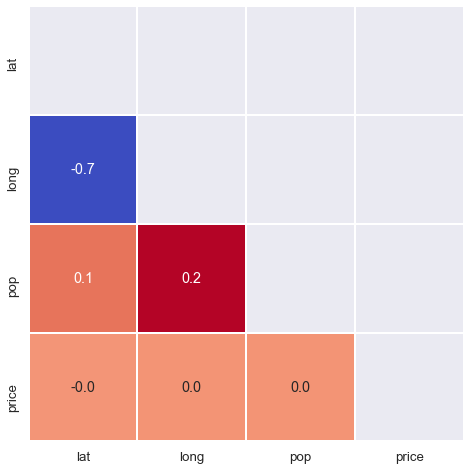

In [9]:
# Display numerical correlations between features.

sns.set(font_scale=1.2)
correlation_train = train.corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False)

plt.show()

<h4>Observations</h4>
<li>We can see there's a negative correlation between quantity and price,
indicating, that quantity tends to get lower as price increases </li>

<h2>Missing Data</h2>
<ul>
    <li>Merge the datasets to see how many missing values there are and visualize them</li>
</ul>

In [10]:
features = pd.concat([X_train, X_test]).reset_index(drop=True)
#Lets see the new shape of the features dataframe
print(features.shape)

(7560, 10)


In [11]:
def missing_percentage(df):
    
    #Defining a function for returning missing ratios
    
    total = df.isnull().sum().sort_values(
        ascending=False)[df.isnull().sum().sort_values(ascending=False) != 0]
    percent = (df.isnull().sum().sort_values(ascending=False) / len(df) *
              100)[(df.isnull().sum().sort_values(ascending=False) / len(df) *
                   100) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])


,long,lat,capacity,container
Total,59.000000,59.000000,19.000000,19.000000
Percent,0.780423,0.780423,0.251323,0.251323


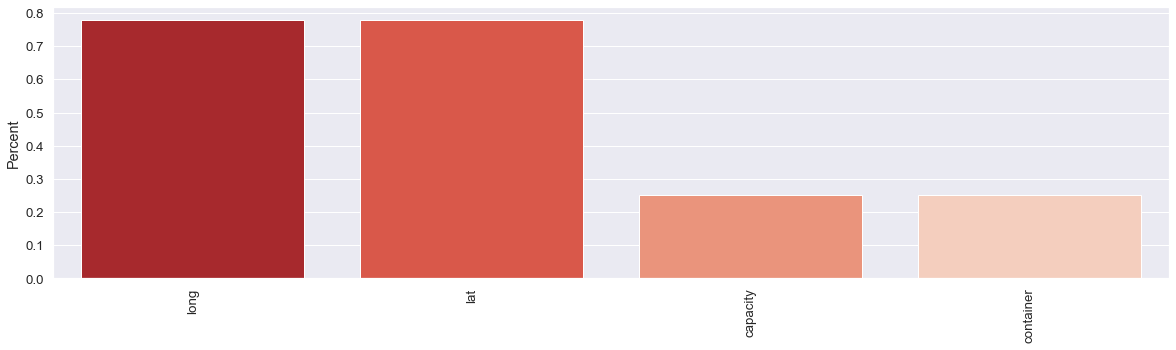

In [12]:
#Checking 'NaN' values.

missing = missing_percentage(features)

fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x=missing.index, y='Percent', data=missing, palette='Reds_r')
plt.xticks(rotation=90)

display(missing.T.style.background_gradient(cmap='Reds', axis=1))


<h2>Pipeline</h2>
<p>Steps:</p>
<ol>
    <li>Extract year, month and day from date so we can use them as numerical features</li>
    <li>Add Year, Month and Day columns to the dataset</li>
    <li>Eliminate date column from the dataset</li>
    <li>
        <ol>
            <li>Fill long, lat, price and pop columns with their mean values</li>
            <li>Fill capacity, brand, shop, container, city, year, month, day with their most-repeated values</li>
        </ol>
    </li>
    <li>One Hot Encode capacity, brand, shop, container, city, year, month and day</li>
    <li>Fit the model</li>
</ol>

In [13]:
#Import neccesary packages to create the pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

C:\Users\Juan\.conda\envs\tf-gpu\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\Juan\.conda\envs\tf-gpu\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [14]:
#Import the BaseEstimator
from sklearn.base import BaseEstimator

#Define pre-processor classes
class DateProcessor(BaseEstimator):

    def __init__(self):
        pass

    def fit(self, documents, y=None):
        return self

    def transform(self, df):
        new_df = df.copy()
        new_df['date'] = pd.to_datetime(new_df['date'], errors="coerce")
        #df.dropna(axis=1, subset=['date'], inplace=True)
        #format="%d%m%Y",errors="ignore"
        new_df['day'] = new_df['date'].dt.day
        new_df['month'] = new_df['date'].dt.month
        new_df['year'] = new_df['date'].dt.year
        
        new_df.drop(inplace=True, columns='date')
        return new_df

class CategoricalProcessor(BaseEstimator):
    def __init__(self):
        pass
    
    def fit(self, documents, y=None):
        return self
    
    def _getDictionary(self, df):
        new_df = df.copy()
        cat_columns = new_df.select_dtypes(include=['object']).columns
        dict = {}
        for col in cat_columns:
            tempMode = new_df.mode()[col][0]
            dict[col] = tempMode
        
        return dict
    
    def transform(self, df):
        new_df = df.copy()
        imputer = self._getDictionary(new_df)
        new_df = new_df.fillna(imputer)
        new_df = pd.get_dummies(new_df)
        
        return new_df
    
class NumericalProcessor(BaseEstimator):
    def __init__(self):
        pass
    
    def fit(self, documents, y=None):
        return self
    
    def _getDictionary(self, df):
        new_df = df.copy()
        num_columns = new_df.select_dtypes(include=['float64', 'int64']).columns
        dict = {}
        for col in num_columns:
            tempMean = new_df[col].mean()
            dict[col] = tempMean
        
        return dict
    
    def transform(self, df):
        new_df = df.copy()
        imputer = self._getDictionary(new_df)
        new_df = new_df.fillna(imputer)
        
        return new_df

In [22]:
#Import the model and GridSearch for Hyperparameter Optimization
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [24]:
#Defining the pipeline
xgb = xgb.XGBRegressor()
model_pipeline = Pipeline(steps=[
                                ('process_date', DateProcessor()),
                                ('num_process', NumericalProcessor()),
                                ('cat_process', CategoricalProcessor()),
                                ('XGBoost', xgb)
                                ])

In [27]:
param_xgb = {'XGBoost__nthread':[4], #when use hyperthread, xgboost may become slower
              'XGBoost__objective':['reg:linear'],
              'XGBoost__learning_rate': [.03, 0.05, .07], #so called `eta` value
              'XGBoost__max_depth': [5, 6, 7],
              'XGBoost__min_child_weight': [4],
              'XGBoost__silent': [1],
              'XGBoost__subsample': [0.7],
              'XGBoost__colsample_bytree': [0.7],
              'XGBoost__tree_method': ['gpu_hist'],
              'XGBoost__n_estimators': [500]}

In [29]:
grid_search_xgb = GridSearchCV(estimator = model_pipeline, param_grid = param_xgb, n_jobs = -1, verbose = 2, cv = 5)
grid_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.2min finished


[15:36:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[15:36:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:36:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('process_date', DateProcessor()),
                                       ('num_process', NumericalProcessor()),
                                       ('cat_process', CategoricalProcessor()),
                                       ('XGBoost',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     gamma=None, gpu_id=None,
                                                     importance_type='gain',
                                                     interaction_constraints=None,
                                                     le...
                                   

In [33]:
#Lets observe the best parameters for our XGBRegressor
print("Best parameter (CV score=%0.3f):" % grid_search_xgb.best_score_)
print(grid_search_xgb.best_params_)

Best parameter (CV score=0.973):
{'XGBoost__colsample_bytree': 0.7, 'XGBoost__learning_rate': 0.07, 'XGBoost__max_depth': 7, 'XGBoost__min_child_weight': 4, 'XGBoost__n_estimators': 500, 'XGBoost__nthread': 4, 'XGBoost__objective': 'reg:linear', 'XGBoost__silent': 1, 'XGBoost__subsample': 0.7, 'XGBoost__tree_method': 'gpu_hist'}


In [35]:
#Score of our model after Hyperparameter optimization
grid_search_xgb.score(X_test, y_test)

0.9661486668861945

In [34]:
#Just to see
grid_search_xgb.score(X_train, y_train)

0.9966150869923057